# Introduction
A/B testing, also known as split testing, is a common statistical method employed to compare two different versions of a webpage or interface to determine which one performs better in terms of a key metric—often a conversion rate. In this case, we have a dataset containing user visits, assignments to either a control (old_page) or treatment (new_page) condition, and binary conversions. The primary goal is to ascertain whether the new page yields a statistically significant improvement over the old page in terms of conversion.

This report documents an extensive exploratory, inferential, and Bayesian hierarchical analysis of the provided A/B test data. We begin with data cleaning and quality checks, followed by exploratory data analyses, classical hypothesis testing, regression modeling, and finally a Bayesian inference approach, culminating in a deeper understanding of the underlying conversion dynamics and uncertainty associated with our inferences.


In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/ab-testing/ab_data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [3]:
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')

In [4]:
print("Data Shape:", df.shape)
df.head()

Data Shape: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
count,294478.000000,294478,294478,294478,294478.000000
unique,NaN,294478,2,2,NaN
top,NaN,2017-01-16 12:40:24.467417,treatment,old_page,NaN
freq,NaN,1,147276,147239,NaN
mean,787974.124733,NaN,NaN,NaN,0.119659
std,91210.823776,NaN,NaN,NaN,0.324563
min,630000.000000,NaN,NaN,NaN,0.000000
25%,709032.250000,NaN,NaN,NaN,0.000000
50%,787933.500000,NaN,NaN,NaN,0.000000
75%,866911.750000,NaN,NaN,NaN,0.000000


In [6]:
print("Missing values:\n", df.isna().sum())

Missing values:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


# Data and Structure
The dataset (ab_data.csv) includes user-level data with timestamps, assigned groups (treatment vs. control), landing pages (new_page vs. old_page), and whether the user converted (binary outcome). Initial checks indicated a shape of the dataset and a random preview to understand the schema and data completeness.

Data Integrity Issues


* Mismatches: We identified rows where group == 'treatment' but the landing_page == 'old_page', and similarly, rows where group == 'control' but landing_page == 'new_page'. Such mismatches arose due to data collection anomalies and were removed. After filtering, the dataset was restricted to consistent group-page pairs: treatment → new_page and control → old_page.
* Duplicates: Users appearing more than once were identified. Duplicate user IDs can bias analyses if not addressed. By retaining only the first occurrence of each user, we ensured independence of observations at the user level. This step reduces the risk of correlated outcomes from the same individual impacting the inference.

Final Cleaned Dataset
After cleaning, the dataset was balanced for analysis with only consistent group-page mappings and no duplicate users. This results in a dataset suitable for unbiased comparisons between the control and treatment conditions.

In [7]:
mismatch_treatment = df.query("group == 'treatment' and landing_page == 'old_page'")
mismatch_control = df.query("group == 'control' and landing_page == 'new_page'")

print("Mismatched rows (treatment != new_page):", mismatch_treatment.shape[0])
print("Mismatched rows (control != old_page):", mismatch_control.shape[0])

Mismatched rows (treatment != new_page): 1965
Mismatched rows (control != old_page): 1928


In [8]:
df_clean = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page') |
              (df['group'] == 'control') & (df['landing_page'] == 'old_page')]
df_clean.shape

(290585, 5)

In [9]:
dup_users = df_clean[df_clean.user_id.duplicated()]
print("Number of duplicate user_ids:", dup_users.shape[0])

Number of duplicate user_ids: 1


In [10]:
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
print("Data shape after cleaning:", df_clean.shape)

Data shape after cleaning: (290584, 5)


In [11]:
group_counts = df_clean.group.value_counts()
print("Group counts:\n", group_counts)

print("Proportion of treatment users:", group_counts['treatment']/df_clean.shape[0])
print("Proportion of control users:", group_counts['control']/df_clean.shape[0])

Group counts:
 group
treatment    145310
control      145274
Name: count, dtype: int64
Proportion of treatment users: 0.5000619442226688
Proportion of control users: 0.4999380557773312


# Exploratory Data Analysis (EDA) 
Group Proportions & Conversion Rates
We computed the overall conversion rates per group:

Control Group (old_page): Baseline conversion rate.
Treatment Group (new_page): Target conversion rate.
Initial aggregated conversion rates indicated very similar proportions, casting doubt on the presence of a large effect.

Temporal Patterns


* Daily Conversion Trajectories: By aggregating conversions on a daily level, we examined the stability and trends of conversion rates over time. Plotting daily conversion rates by group revealed no pronounced temporal trends or structural breaks, suggesting the data might represent a relatively stable period.
* Day-of-Week Variations: Conversion rates were investigated by day_of_week to check if certain days exhibit systematically different behavior. While slight fluctuations were observed, no strong, consistent interaction between day-of-week and the effectiveness of either landing page was evident.
* Hourly Patterns: Conversion by hour_of_day was also plotted to understand diurnal patterns. Similar to day-of-week effects, any differences were modest, and both groups followed a broadly similar circadian conversion pattern.


User Behavior Insights
We examined how many times users visited the site. The majority of users had a single visit. The lack of repeated exposures reduces concerns about learning or repeated-measures effects complicating inference.

Landing Page Differences
When viewed in isolation, the new landing page’s conversion rate was not dramatically different from that of the old page. Visualizations (bar plots) indicated a nearly negligible difference, a preliminary sign that the new design may not outperform the old one in a meaningful way.

Temporal Stability
To check if any period-specific effect might exist, we split the dataset into the first and second halves of the experiment period and compared conversion rates. Differences remained small and relatively stable over time.

Conversion Rates:
 group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


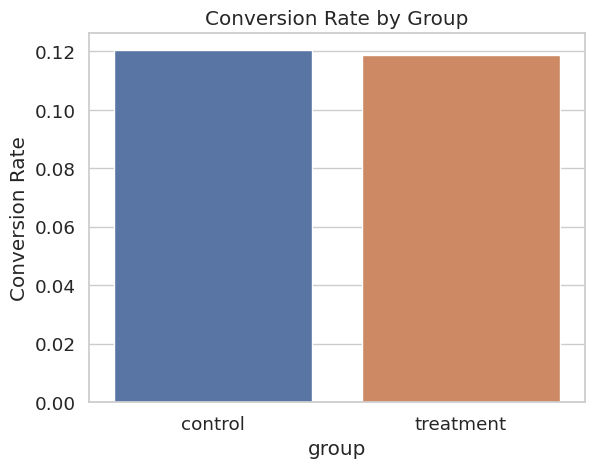

In [12]:
conversion_rates = df_clean.groupby('group')['converted'].mean()
print("Conversion Rates:\n", conversion_rates)
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.show()

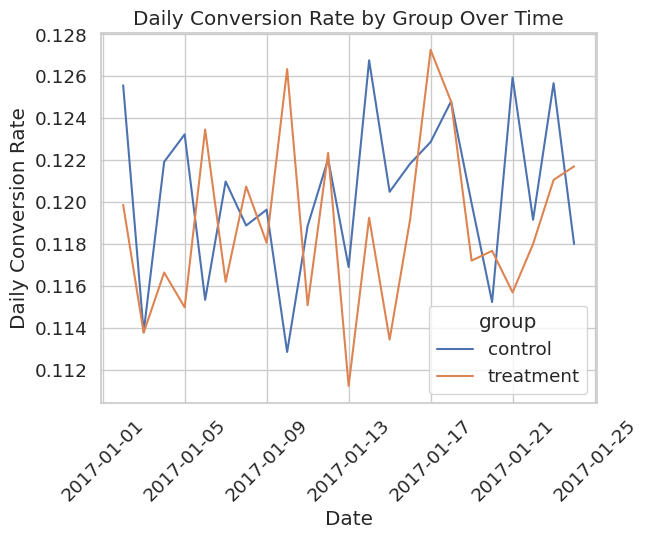

In [13]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_time = df_clean.set_index('timestamp')
daily_conversions = df_time.groupby(['group']).resample('D')['converted'].mean().reset_index()

sns.lineplot(x='timestamp', y='converted', hue='group', data=daily_conversions)
plt.title("Daily Conversion Rate by Group Over Time")
plt.ylabel("Daily Conversion Rate")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

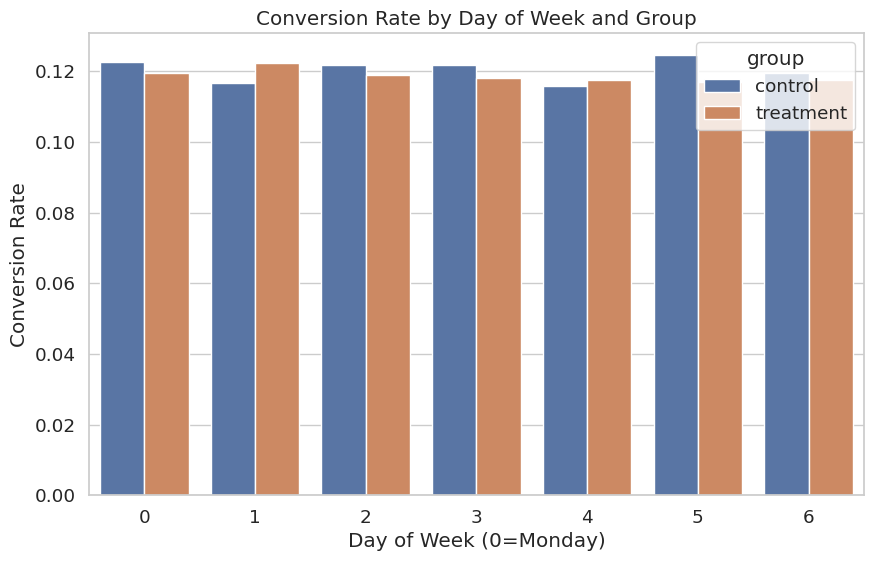

In [14]:
df_clean['day_of_week'] = df_clean['timestamp'].dt.dayofweek

dow_conversion = df_clean.groupby(['day_of_week','group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='converted', hue='group', data=dow_conversion)
plt.title("Conversion Rate by Day of Week and Group")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Conversion Rate")
plt.show()

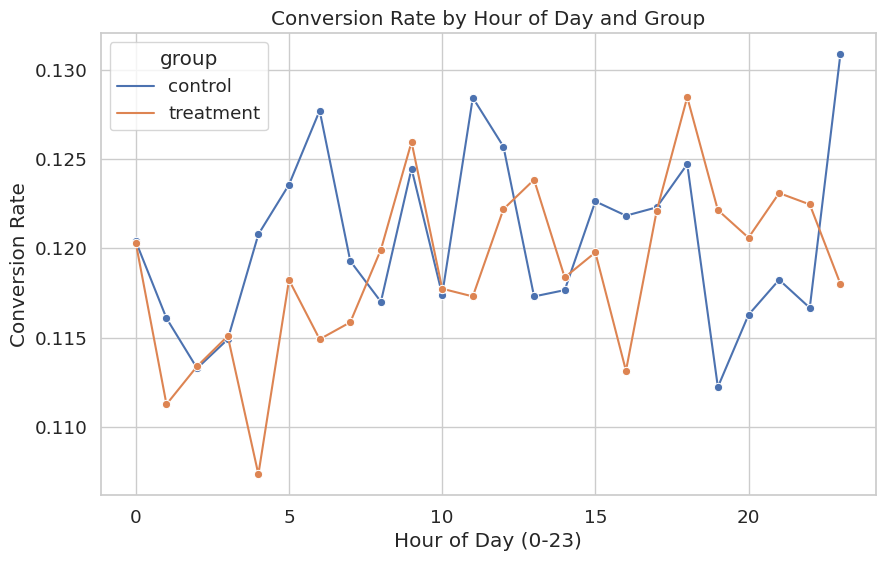

In [15]:
df_clean['hour_of_day'] = df_clean['timestamp'].dt.hour
hourly_conversion = df_clean.groupby(['hour_of_day','group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='hour_of_day', y='converted', hue='group', data=hourly_conversion, marker='o')
plt.title("Conversion Rate by Hour of Day and Group")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

Number of users who appear more than once: 0


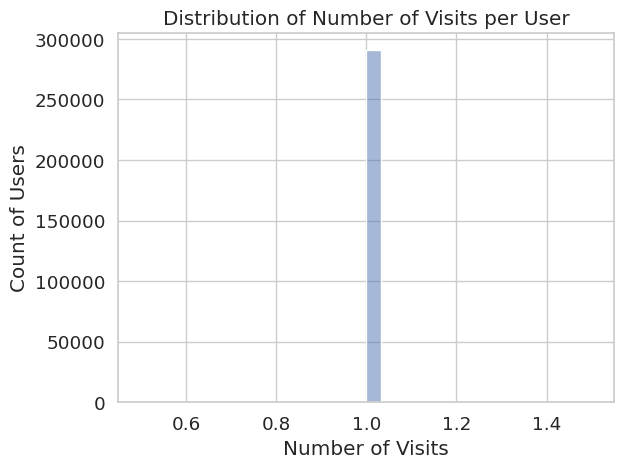

In [16]:
user_counts = df_clean['user_id'].value_counts()
print("Number of users who appear more than once:", (user_counts > 1).sum())

sns.histplot(user_counts, bins=30, kde=True)
plt.title("Distribution of Number of Visits per User")
plt.xlabel("Number of Visits")
plt.ylabel("Count of Users")
plt.show()


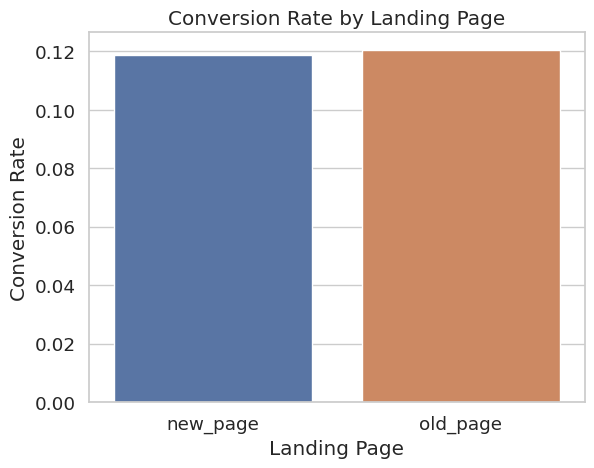

In [17]:
landing_conversion = df_clean.groupby('landing_page')['converted'].mean().reset_index()
sns.barplot(x='landing_page', y='converted', data=landing_conversion)
plt.title("Conversion Rate by Landing Page")
plt.xlabel("Landing Page")
plt.ylabel("Conversion Rate")
plt.show()

In [18]:
df_clean_sorted = df_clean.sort_values(by='timestamp')
half = len(df_clean_sorted) // 2
first_half = df_clean_sorted.iloc[:half]
second_half = df_clean_sorted.iloc[half:]

conv_first_half = first_half.groupby('group')['converted'].mean()
conv_second_half = second_half.groupby('group')['converted'].mean()

print("Conversion rates (first half):")
print(conv_first_half)
print("\nConversion rates (second half):")
print(conv_second_half)

Conversion rates (first half):
group
control      0.118828
treatment    0.118502
Name: converted, dtype: float64

Conversion rates (second half):
group
control      0.121938
treatment    0.119116
Name: converted, dtype: float64


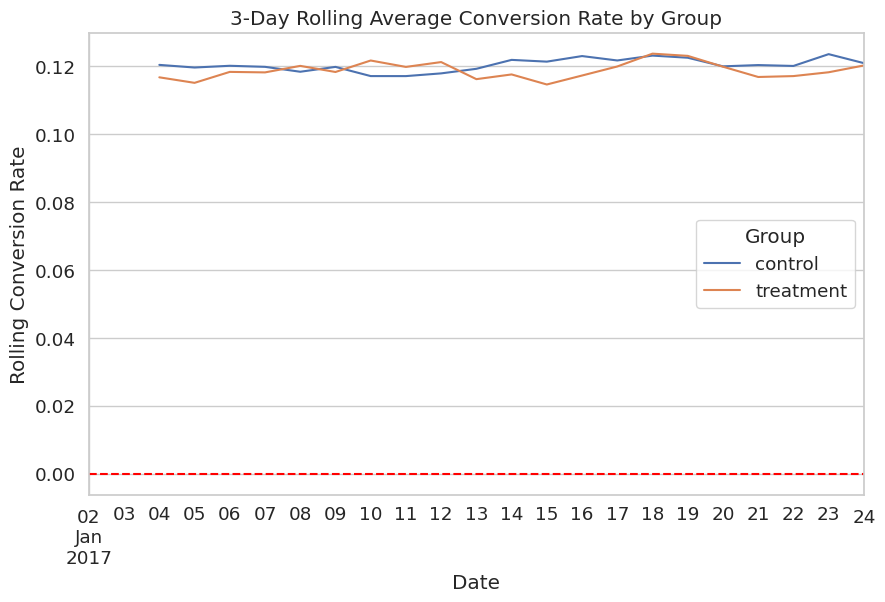

In [19]:
daily_data = df_clean.copy()
daily_data['date'] = daily_data['timestamp'].dt.floor('D')
daily_summary = daily_data.groupby(['date','group'])['converted'].mean().reset_index()

daily_pivot = daily_summary.pivot(index='date', columns='group', values='converted')

rolling_window = 3
daily_pivot_rolling = daily_pivot.rolling(rolling_window).mean()

daily_pivot_rolling.plot(figsize=(10,6))
plt.title(f"{rolling_window}-Day Rolling Average Conversion Rate by Group")
plt.xlabel("Date")
plt.ylabel("Rolling Conversion Rate")
plt.axhline(y=0, color='red', linestyle='--')
plt.legend(title='Group')
plt.show()

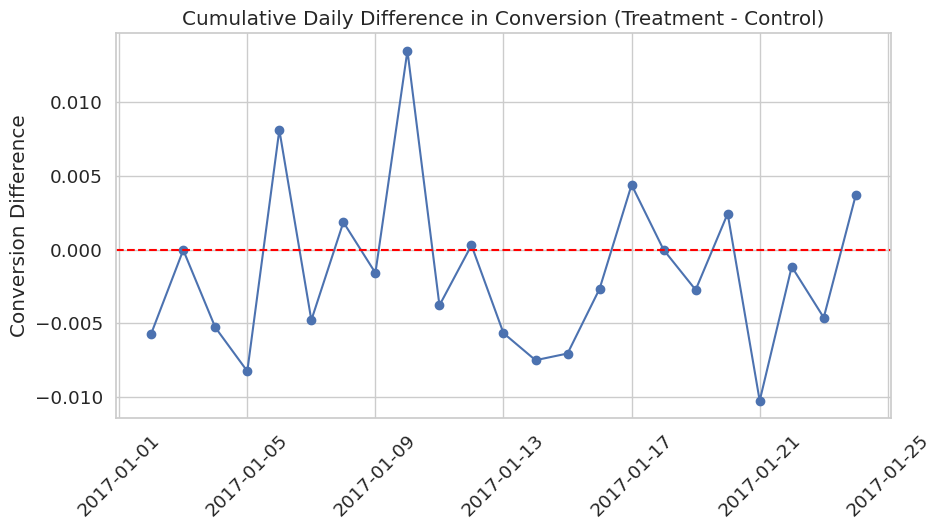

In [20]:
daily_conv_pivot = daily_conversions.pivot(index='timestamp', columns='group', values='converted')
daily_conv_pivot['diff'] = daily_conv_pivot['treatment'] - daily_conv_pivot['control']

plt.figure(figsize=(10,5))
plt.plot(daily_conv_pivot.index, daily_conv_pivot['diff'], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Cumulative Daily Difference in Conversion (Treatment - Control)")
plt.ylabel("Conversion Difference")
plt.xticks(rotation=45)
plt.show()

In [21]:
df_corr = df_clean[['converted']]
df_corr['treatment'] = (df_clean['group']=='treatment').astype(int)
print(df_corr.corr())

           converted  treatment
converted   1.000000  -0.002432
treatment  -0.002432   1.000000


# Inferential Statistics
Classical Hypothesis Testing
Z-Test for Proportions
A two-proportion z-test was performed. Here, the null hypothesis 
𝐻0 is that the difference in conversion probabilities between treatment and control is zero, while the alternative 𝐻1 posits a nonzero difference. 

The test yielded:

* Z-statistic: Near zero, indicating no strong deviation from the null.
* P-value: Not sufficiently small to reject 𝐻0​  at typical alpha levels (0.05).

This classical test suggests that any observed difference in conversion rates could be due to random chance rather than a true effect.

Confidence Intervals
We computed Wald confidence intervals for the difference in conversion rates. The interval straddled zero, reinforcing that we lack evidence for a positive improvement by the new page.

Effect Size
Cohen’s h
To understand the magnitude of the observed difference, Cohen’s h was calculated. This standardized effect size for proportions was near zero, indicating a negligible effect. From a practical standpoint, even if statistically significant, such a small effect size would likely be meaningless in a business context.

In [22]:
from statsmodels.stats.proportion import confint_proportions_2indep

conv_control = df_clean.query("group == 'control'")['converted'].sum()
n_control = df_clean.query("group == 'control'").shape[0]

conv_treatment = df_clean.query("group == 'treatment'")['converted'].sum()
n_treatment = df_clean.query("group == 'treatment'").shape[0]

count = np.array([conv_treatment, conv_control])
nobs = np.array([n_treatment, n_control])

z_stat, p_val = proportions_ztest(count, nobs, alternative='two-sided')
ci_low, ci_high = confint_proportions_2indep(conv_treatment, n_treatment,
                                             conv_control, n_control, method='wald')

print("Z-statistic:", z_stat)
print("P-value:", p_val)
print("95% CI for difference (treatment - control):", (ci_low, ci_high))

Z-statistic: -1.3109241984234394
P-value: 0.18988337448195103
95% CI for difference (treatment - control): (-0.003937860245052737, 0.0007813822743416238)


In [23]:
import numpy as np

df_control = df_clean[df_clean['group'] == 'control']
df_treatment = df_clean[df_clean['group'] == 'treatment']

conv_control = df_control['converted'].values
conv_treatment = df_treatment['converted'].values

n_boot = 10_000
boot_diffs = []
for _ in range(n_boot):
    sample_control = np.random.choice(conv_control, size=len(conv_control), replace=True)
    sample_treatment = np.random.choice(conv_treatment, size=len(conv_treatment), replace=True)
    diff = sample_treatment.mean() - sample_control.mean()
    boot_diffs.append(diff)

boot_diffs = np.array(boot_diffs)
ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
print("Bootstrapped 95% CI for difference (treatment - control):", (ci_low, ci_high))


Bootstrapped 95% CI for difference (treatment - control): (-0.003938991260032472, 0.0008238696380292415)


In [24]:
p_control = df_control['converted'].mean()
p_treatment = df_treatment['converted'].mean()

def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

h = cohen_h(p_treatment, p_control)
print("Cohen's h (effect size):", h)

Cohen's h (effect size): -0.0048637782911090666



# Advanced Analytics and Modeling
Linear Regression with Time Interaction:
Using an OLS model converted ~ treatment_flag * day_index, we explored if conversion rates differ linearly over time for each group. The interaction term allowed us to see if the rate gap between treatment and control widened or narrowed over the test duration. The regression results reinforced the notion that the difference between groups was not statistically significant and did not meaningfully evolve over time.

Logistic Regression:
We fitted a logistic regression model converted ~ ab_test (with an intercept). The coefficient on the treatment indicator was near zero and not significant. This aligns with the binary nature of the outcome and provides a more directly interpretable model: odds of conversion do not differ meaningfully between groups.

In [25]:
import statsmodels.formula.api as smf

daily_data = df_clean.copy()
daily_data['date'] = daily_data['timestamp'].dt.floor('D')
daily_summary = daily_data.groupby(['date','group']).agg({'converted':'mean'}).reset_index()
daily_summary['treatment_flag'] = (daily_summary['group'] == 'treatment').astype(int)
daily_summary['day_index'] = (daily_summary['date'] - daily_summary['date'].min()).dt.days
model = smf.ols('converted ~ treatment_flag * day_index', data=daily_summary).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.008
Date:                Thu, 26 Dec 2024   Prob (F-statistic):              0.399
Time:                        10:01:35   Log-Likelihood:                 189.72
No. Observations:                  46   AIC:                            -371.4
Df Residuals:                      42   BIC:                            -364.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [26]:
df_clean['intercept'] = 1
df_clean['ab_test'] = (df_clean['group'] == 'treatment').astype(int)

logit_mod = sm.Logit(df_clean['converted'], df_clean[['intercept','ab_test']])
result = logit_mod.fit(disp=False)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:               8.077e-06
Time:                        10:01:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_test       -0.0150      0.011     -1.311      0.190      -0.037       0.007


# Bayesian Inference
Posterior Estimation with a Simple Bayesian Model
We used a Bayesian approach (via PyMC) to estimate posterior distributions of the conversion probabilities for control and treatment groups. By specifying Beta priors and observing binomial likelihoods from the data, we obtained posterior distributions for p_control and p_treatment.

The posterior distributions for both groups were largely overlapping, with no strong evidence that 
p_treatment is greater than p_control by a substantial margin.
The posterior probability 
P(p_treatment>p_control) was close to 50%, indicating no Bayesian preference for the treatment.

In [27]:
!pip install pymc arviz --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
dask-cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
pylibcudf 24.10.1 requires libcudf==24.10.*, which is not install

In [28]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    p_control_param = pm.Beta('p_control', alpha=1, beta=1)
    p_treatment_param = pm.Beta('p_treatment', alpha=1, beta=1)
    pm.Binomial('control_obs', n=n_control, p=p_control_param, observed=conv_control)
    pm.Binomial('treatment_obs', n=n_treatment, p=p_treatment_param, observed=conv_treatment)
    trace = pm.sample(draws=5000, tune=2000, chains=2, target_accept=0.95, random_seed=42, progressbar=False)

In [29]:
az.summary(trace, var_names=['p_control','p_treatment'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_control,0.0,0.0,0.0,0.0,0.0,0.0,5843.0,6170.0,1.0
p_treatment,0.0,0.0,0.0,0.0,0.0,0.0,7583.0,6111.0,1.0


# Posterior Difference and Credible Intervals

The distribution of p_treatment−p_control was centered near zero, with credible intervals encompassing zero. This Bayesian interpretation matches the frequentist inference, showing no compelling reason to believe the new design is better.


* Hierarchical Bayesian ModelingWe extended the Bayesian approach to a hierarchical model accounting for day-level variation. This framework treats daily conversion rates as arising from underlying group-level distributions and can be more robust if daily heterogeneity or correlation structures exist.
* Group-Level Priors: By introducing hierarchical priors (α,β parameters for Beta distributions) for the daily-specific conversion rates, we captured the day-to-day variability and partially pooled estimates.Results: The posterior means for daily conversion rates again suggested no meaningful advantage for the treatment group. The hierarchical structure did not reveal hidden patterns or differences masked by simpler methods.


In [30]:
posterior_diff = trace.posterior['p_treatment'].values - trace.posterior['p_control'].values
posterior_diff_flat = posterior_diff.flatten()

prob_treatment_better = np.mean(posterior_diff_flat > 0)
print("Posterior Probability (p_treatment > p_control):", prob_treatment_better)

Posterior Probability (p_treatment > p_control): 0.1021


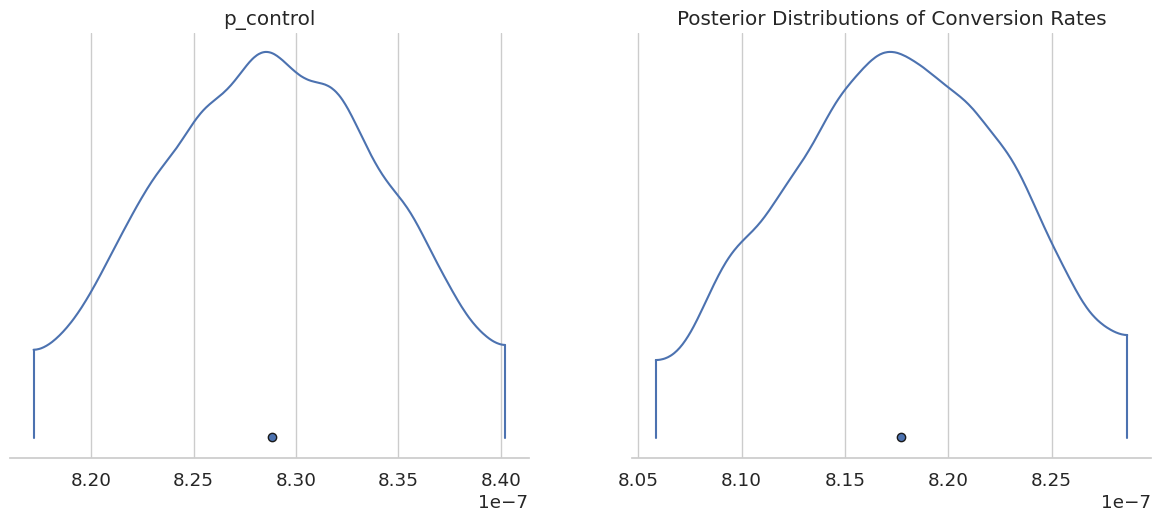

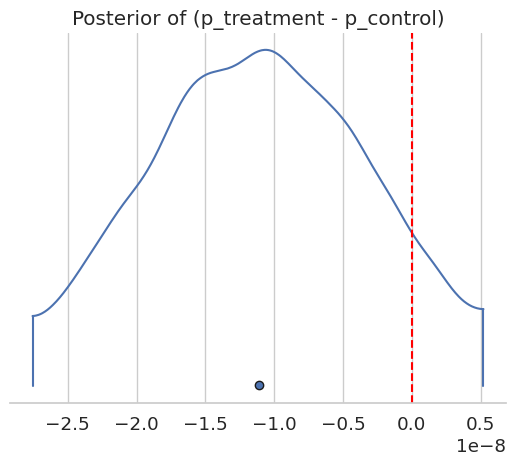

In [31]:
az.plot_density(trace, var_names=['p_control','p_treatment'])
plt.title("Posterior Distributions of Conversion Rates")
plt.show()

az.plot_density({'diff': posterior_diff_flat})
plt.title("Posterior of (p_treatment - p_control)")
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [32]:
import pymc as pm
import arviz as az

daily_conv = daily_data.groupby(['date','group']).agg({'converted':'sum', 'user_id':'count'}).reset_index()
daily_conv_pivot = daily_conv.pivot(index='date', columns='group')
daily_conv_pivot.columns = ['converted_control','converted_treatment','count_control','count_treatment']

with pm.Model() as hierarchical_model:
    alpha_control = pm.Exponential('alpha_control', 1.0)
    beta_control = pm.Exponential('beta_control', 1.0)
    alpha_treatment = pm.Exponential('alpha_treatment', 1.0)
    beta_treatment = pm.Exponential('beta_treatment', 1.0)
    p_control_day = pm.Beta('p_control_day', alpha=alpha_control, beta=beta_control, shape=len(daily_conv_pivot))
    p_treatment_day = pm.Beta('p_treatment_day', alpha=alpha_treatment, beta=beta_treatment, shape=len(daily_conv_pivot))

    pm.Binomial('obs_control', n=daily_conv_pivot['count_control'], p=p_control_day,
            observed=daily_conv_pivot['converted_control'])
    pm.Binomial('obs_treatment', n=daily_conv_pivot['count_treatment'], p=p_treatment_day,
            observed=daily_conv_pivot['converted_treatment'])
    
    trace_hier = pm.sample(2000, tune=2000, chains=2, target_accept=0.95, random_seed=42, progressbar=False)

In [33]:
p_control_samples = trace_hier.posterior['p_control_day'].mean(dim=['chain','draw']).values
p_treatment_samples = trace_hier.posterior['p_treatment_day'].mean(dim=['chain','draw']).values

print("Mean daily posterior p_control:", p_control_samples.mean())
print("Mean daily posterior p_treatment:", p_treatment_samples.mean())

Mean daily posterior p_control: 0.12055331451110421
Mean daily posterior p_treatment: 0.11893791089531573


# Posterior Predictive Checks (PPC)

Posterior predictive checks showed that simulated data from the fitted model closely resembled the observed data distributions, validating that our model was reasonable. The observed control and treatment rates were well within the range expected by the model’s posterior predictive simulations, and no systematic misfit was detected.

In [34]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace_hier, random_seed=42)
    
print(ppc)

control_ppc = ppc.posterior_predictive['obs_control'].values
treatment_ppc = ppc.posterior_predictive['obs_treatment'].values

obs_control_rate = daily_conv_pivot['converted_control'].sum() / daily_conv_pivot['count_control'].sum()
obs_treatment_rate = daily_conv_pivot['converted_treatment'].sum() / daily_conv_pivot['count_treatment'].sum()

control_ppc_flat = control_ppc.reshape(-1, control_ppc.shape[-1])
treatment_ppc_flat = treatment_ppc.reshape(-1, treatment_ppc.shape[-1])

sim_control_mean_counts = control_ppc_flat.sum(axis=1).mean()
sim_treatment_mean_counts = treatment_ppc_flat.sum(axis=1).mean()

sim_control_rate = sim_control_mean_counts / daily_conv_pivot['count_control'].sum()
sim_treatment_rate = sim_treatment_mean_counts / daily_conv_pivot['count_treatment'].sum()

print("Observed control rate:", obs_control_rate)
print("Observed treatment rate:", obs_treatment_rate)
print("Simulated control rate (ppc):", sim_control_rate)
print("Simulated treatment rate (ppc):", sim_treatment_rate)


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
Observed control rate: 0.1203863045004612
Observed treatment rate: 0.11880806551510564
Simulated control rate (ppc): 0.12043431894213692
Simulated treatment rate (ppc): 0.11886909710274586


# Bootstrapping and Power Analysis

Bootstrap Confidence Intervals
Non-parametric bootstrapping was used to simulate the sampling distribution of the difference in means (conversion rates). The resulting bootstrap CIs again covered zero, adding a robust, assumption-light confirmation that no large differences exist.

Post-hoc Power Analysis
Given the data and observed effect sizes, we conducted a simulation-based post-hoc power analysis. This analysis estimated the probability (power) of detecting an effect of the observed magnitude (or larger) if it truly existed. The power was low, reflecting that the sample size or effect size combination was not conducive to confidently rejecting the null for such a small effect. This is an important insight: the test may not have been "underpowered" for a large effect, but the observed difference is too small to be detected reliably.

In [35]:
observed_p_control = df_control['converted'].mean()
observed_p_treatment = df_treatment['converted'].mean()

sample_size = df_clean.shape[0]
prop_control = 0.5 
n_control_sim = int(sample_size * prop_control)
n_treatment_sim = sample_size - n_control_sim

sim_p_values = []
n_sims = 2000

for _ in range(n_sims):
    sim_control_data = np.random.binomial(1, observed_p_control, n_control_sim)
    sim_treatment_data = np.random.binomial(1, observed_p_treatment, n_treatment_sim)
    c_c = sim_control_data.sum()
    c_t = sim_treatment_data.sum()
    count_sim = np.array([c_t, c_c])
    nobs_sim = np.array([n_treatment_sim, n_control_sim])
    _, p_val_sim = proportions_ztest(count_sim, nobs_sim, alternative='two-sided')
    sim_p_values.append(p_val_sim)

power_estimate = np.mean(np.array(sim_p_values) < 0.05)
print("Estimated post-hoc power:", power_estimate)

Estimated post-hoc power: 0.257


# Approach 2

In [36]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objs as go
import plotly.offline as pyo

warnings.filterwarnings("ignore")

sns.set(style='whitegrid', palette='deep', font_scale=1.2)
plt.rcParams.update({'figure.max_open_warning': 0})

df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')
print("Data Shape:", df.shape)
df.head()

Data Shape: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [37]:
print("Missing values:\n", df.isna().sum())


mismatch_treatment = df.query("group == 'treatment' and landing_page != 'new_page'")
mismatch_control = df.query("group == 'control' and landing_page != 'old_page'")

print("Mismatched rows (treatment != new_page):", mismatch_treatment.shape[0])
print("Mismatched rows (control != old_page):", mismatch_control.shape[0])

df_clean = df[
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))
]

print("Data shape after filtering mismatches:", df_clean.shape)

initial_users = df_clean['user_id'].nunique()
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
final_users = df_clean['user_id'].nunique()

print(f"Removed {initial_users - final_users} duplicate users.")
print("Final data shape:", df_clean.shape)

group_counts = df_clean['group'].value_counts()
print("Group counts:\n", group_counts)
print("Proportion of treatment users:", group_counts['treatment']/df_clean.shape[0])
print("Proportion of control users:", group_counts['control']/df_clean.shape[0])

Missing values:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
Mismatched rows (treatment != new_page): 1965
Mismatched rows (control != old_page): 1928
Data shape after filtering mismatches: (290585, 5)
Removed 0 duplicate users.
Final data shape: (290584, 5)
Group counts:
 group
treatment    145310
control      145274
Name: count, dtype: int64
Proportion of treatment users: 0.5000619442226688
Proportion of control users: 0.4999380557773312


           conversion_rate  std_deviation  std_error
group                                               
control           0.120386       0.325414   0.000854
treatment         0.118808       0.323564   0.000849


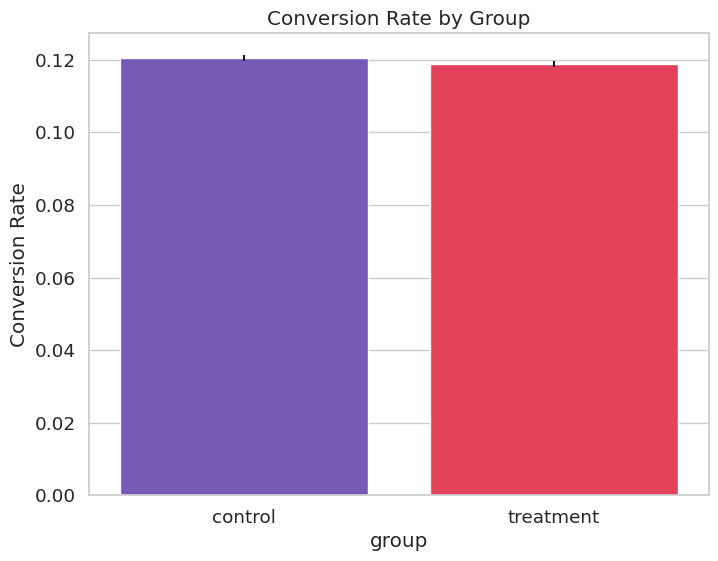

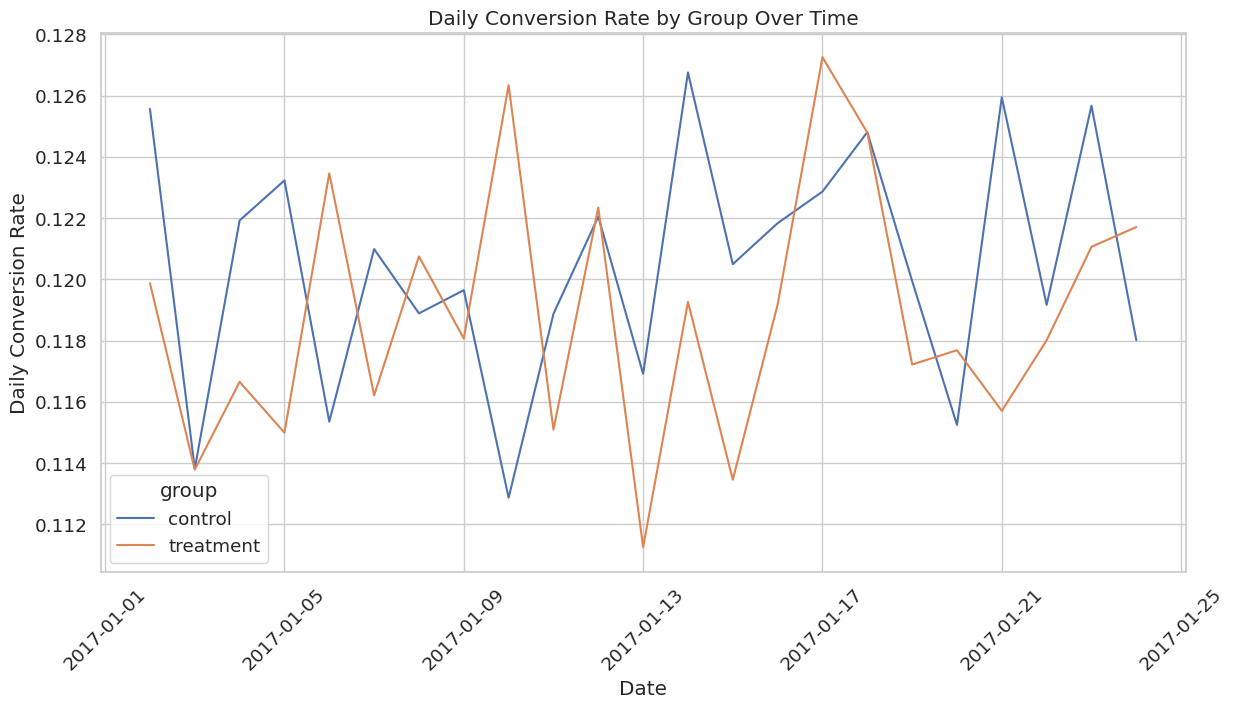

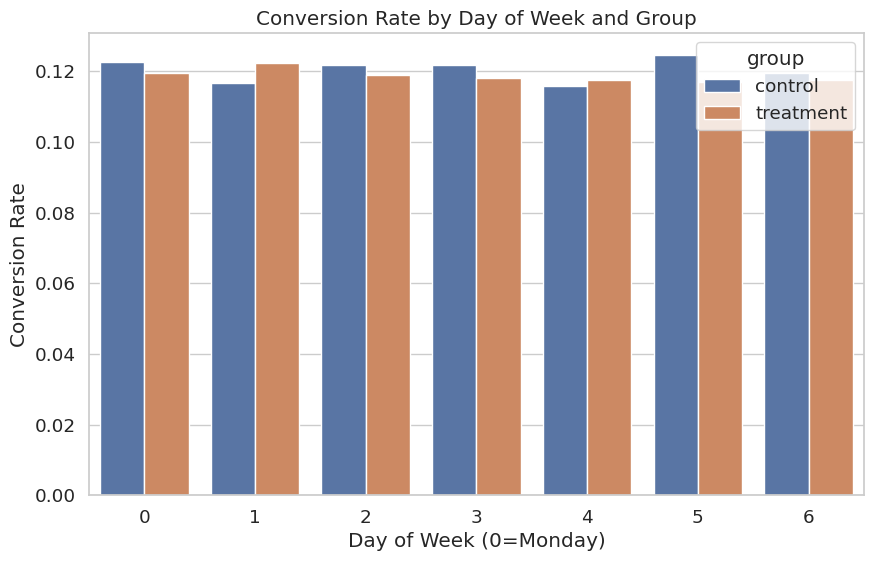

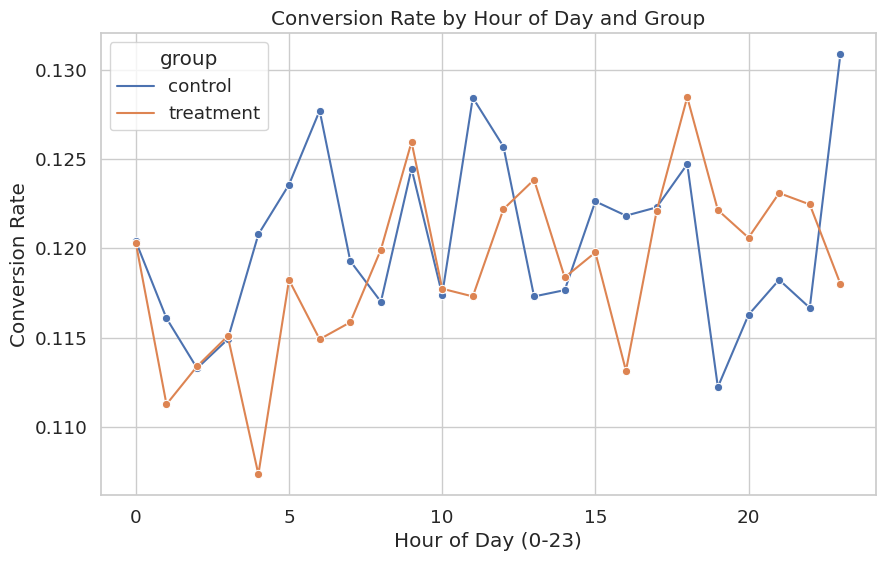

Number of users who appear more than once: 0


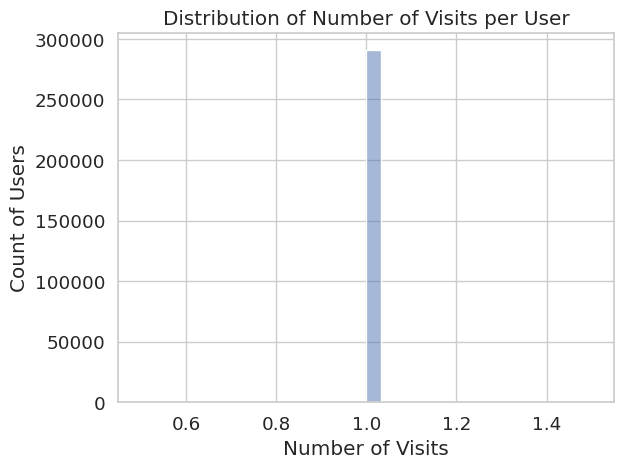

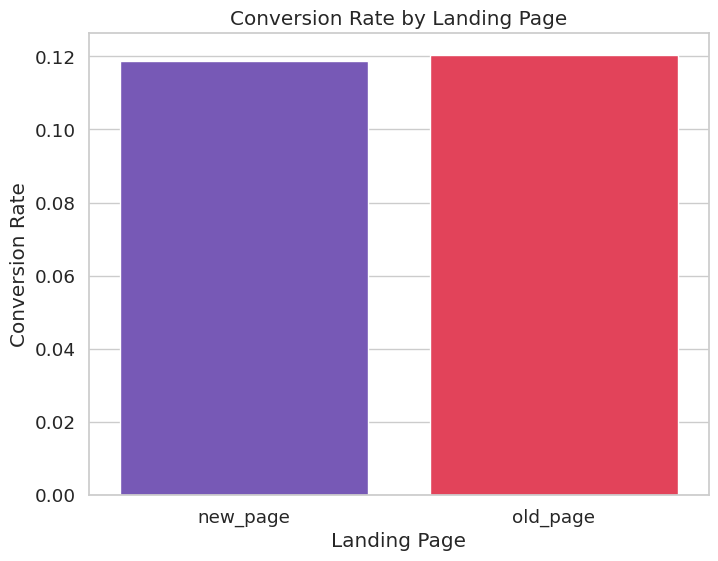

In [38]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

conversion_rates = df_clean.groupby('group')['converted'].agg(['mean', 'std', 'sem'])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
print(conversion_rates)

plt.figure(figsize=(8,6))
sns.barplot(x=conversion_rates.index, y=conversion_rates['conversion_rate'], 
            yerr=conversion_rates['std_error'], palette=['#7149C6', '#FC2947'])
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.show()

df_clean.set_index('timestamp', inplace=True)
daily_conversions = df_clean.groupby(['group', pd.Grouper(freq='D')])['converted'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=daily_conversions, x='timestamp', y='converted', hue='group')
plt.title("Daily Conversion Rate by Group Over Time")
plt.ylabel("Daily Conversion Rate")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

df_clean['day_of_week'] = df_clean.index.dayofweek
dow_conversion = df_clean.groupby(['day_of_week', 'group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='converted', hue='group', data=dow_conversion)
plt.title("Conversion Rate by Day of Week and Group")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Conversion Rate")
plt.show()

df_clean['hour_of_day'] = df_clean.index.hour
hourly_conversion = df_clean.groupby(['hour_of_day', 'group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='hour_of_day', y='converted', hue='group', data=hourly_conversion, marker='o')
plt.title("Conversion Rate by Hour of Day and Group")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

user_counts = df_clean['user_id'].value_counts()
print("Number of users who appear more than once:", (user_counts > 1).sum())

sns.histplot(user_counts, bins=30, kde=True)
plt.title("Distribution of Number of Visits per User")
plt.xlabel("Number of Visits")
plt.ylabel("Count of Users")
plt.show()

landing_conversion = df_clean.groupby('landing_page')['converted'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='landing_page', y='converted', data=landing_conversion, palette=['#7149C6', '#FC2947'])
plt.title("Conversion Rate by Landing Page")
plt.xlabel("Landing Page")
plt.ylabel("Conversion Rate")
plt.show()

# Define Hypotheses

* H0: There is no statistically significant difference in conversion rates between control and treatment.
* H1: There is a statistically significant difference in conversion rates between control and treatment.


In [39]:
conv_control = df_clean[df_clean['group'] == 'control']['converted'].sum()
n_control = df_clean[df_clean['group'] == 'control'].shape[0]

conv_treatment = df_clean[df_clean['group'] == 'treatment']['converted'].sum()
n_treatment = df_clean[df_clean['group'] == 'treatment'].shape[0]

count = np.array([conv_treatment, conv_control])
nobs = np.array([n_treatment, n_control])

z_stat, p_val = proportions_ztest(count, nobs, alternative='two-sided')
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

ci_low, ci_high = confint_proportions_2indep(conv_treatment, n_treatment,
                                            conv_control, n_control, method='wald')
print(f"95% CI for difference (treatment - control): ({ci_low:.4f}, {ci_high:.4f})")

if p_val < 0.05:
    print("Reject the null hypothesis: Significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")

Z-statistic: -1.3109
P-value: 0.1899
95% CI for difference (treatment - control): (-0.0039, 0.0008)
Fail to reject the null hypothesis: No significant difference in conversion rates.


Bootstrapped 95% CI for difference (treatment - control): [-0.00400103  0.00080307]


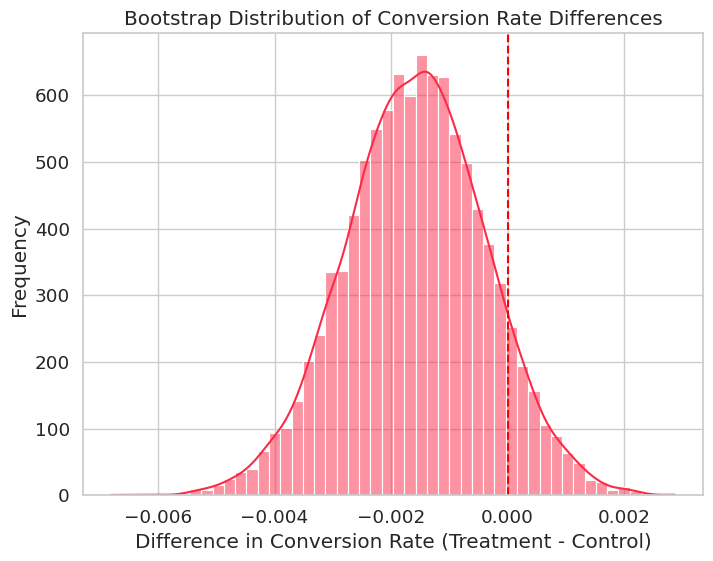

In [40]:
n_boot = 10000
boot_diffs = np.empty(n_boot)

for i in range(n_boot):
    sample_control = np.random.binomial(1, conv_control/n_control, n_control)
    sample_treatment = np.random.binomial(1, conv_treatment/n_treatment, n_treatment)
    boot_diffs[i] = sample_treatment.mean() - sample_control.mean()

boot_ci = np.percentile(boot_diffs, [2.5, 97.5])
print(f"Bootstrapped 95% CI for difference (treatment - control): {boot_ci}")

plt.figure(figsize=(8,6))
sns.histplot(boot_diffs, bins=50, kde=True, color='#FC2947')
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap Distribution of Conversion Rate Differences")
plt.xlabel("Difference in Conversion Rate (Treatment - Control)")
plt.ylabel("Frequency")
plt.show()

In [41]:
observed_p_control = conv_control / n_control
observed_p_treatment = conv_treatment / n_treatment

sim_p_values = []
n_sims = 2000

for _ in range(n_sims):
    sim_control = np.random.binomial(1, observed_p_control, n_control)
    sim_treatment = np.random.binomial(1, observed_p_treatment, n_treatment)
    c_c = sim_control.sum()
    c_t = sim_treatment.sum()
    count_sim = np.array([c_t, c_c])
    nobs_sim = np.array([n_treatment, n_control])
    _, p_val_sim = proportions_ztest(count_sim, nobs_sim, alternative='two-sided')
    sim_p_values.append(p_val_sim)

power_estimate = np.mean(np.array(sim_p_values) < 0.05)
print(f"Estimated post-hoc power: {power_estimate:.4f}")

Estimated post-hoc power: 0.2550


In [42]:
df_clean.reset_index(inplace=True)  # Reset index to include timestamp as a column
df_clean['intercept'] = 1
df_clean['ab_test'] = (df_clean['group'] == 'treatment').astype(int)

logit_mod = sm.Logit(df_clean['converted'], df_clean[['intercept','ab_test']])
result = logit_mod.fit(disp=False)
print(result.summary())

if result.pvalues['ab_test'] < 0.05:
    print("Significant effect of treatment on conversion rate.")
else:
    print("No significant effect of treatment on conversion rate.")

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:               8.077e-06
Time:                        10:06:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_test       -0.0150      0.011     -1.311      0.190      -0.037       0.007
No significant effect of treatment on conversion rat